# Дополнительная лабораторная работа. Методы обучения без учителя

## Импорт библиотек

In [44]:
# Core
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import plotly.express as px

# Sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.metrics import silhouette_score

## Загрузка датасета

**Источник:** https://www.kaggle.com/datasets/harrywang/wine-dataset-for-clustering/data

Данный набор данных представляет собой результаты химического анализа вин, произведенных в одном и том же регионе Италии из **трёх различных сортов** винограда. 

**Признаки:**

1. Alcohol (Этиловый спирт)
2. Malic acid (Яблочная кислота)
3. Ash (Зольность)
4. Alcalinity of ash (Щелочность золы)
5. Magnesium (Магний)
6. Total phenols (Общая концентрация фенолов)
7. Flavanoids (Флавоноиды)
8. Nonflavanoid phenols (Нефлавоноидные фенолы)
9. Proanthocyanins (Проантоцианидины)
10. Color intensity (Интенсивность окраски)
11. Hue (Тон/оттенок)
12. OD280/OD315 of diluted wines (Показатель поглощения при 280/315 нм у разбавленного вина)
13. Proline (Пролин)

In [45]:
data=pd.read_csv('wine-clustering.csv')

data.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Первичный анализ датасета

In [46]:
print(f'Размеры датафрейма: {data.shape}')
print('')
print(f'Пропуски: {data.isna().sum().sum()}')
print('')
print(f'Дубликаты: {data.duplicated().sum()}')

Размеры датафрейма: (178, 13)

Пропуски: 0

Дубликаты: 0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


## Масштабирование данных

In [48]:
scaler =StandardScaler()
X=pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


## Метод главных компонент (PCA)

Метод главных компонент (англ. Principal Components Analysis, PCA) — способ уменьшить размерность данных. 
Изобретен К. Пирсоном (англ. Karl Pearson) в 1901 г.

Метод аппроксимирует n-размерное облако наблюдений до эллипсоида (тоже n-мерного), полуоси которого и будут являться будущими главными компонентами. И при проекции на такие оси (снижении размерности) сохраняется наибольшее количество информации. Вычисление главных компонент сводится к вычислению собственных векторов и собственных значений ковариационной матрицы исходных данных или к сингулярному разложению матрицы данных.

In [49]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])

print(f'Размер датасета: {df_pca.shape}')
df_pca.head()

Размер датасета: (178, 2)


,PC1,PC2
0,3.316751,1.443463
1,2.209465,-0.333393
2,2.516740,1.031151
3,3.757066,2.756372
4,1.008908,0.869831


### Визуализация PCA в 2D

Text(0, 0.5, 'PC2')

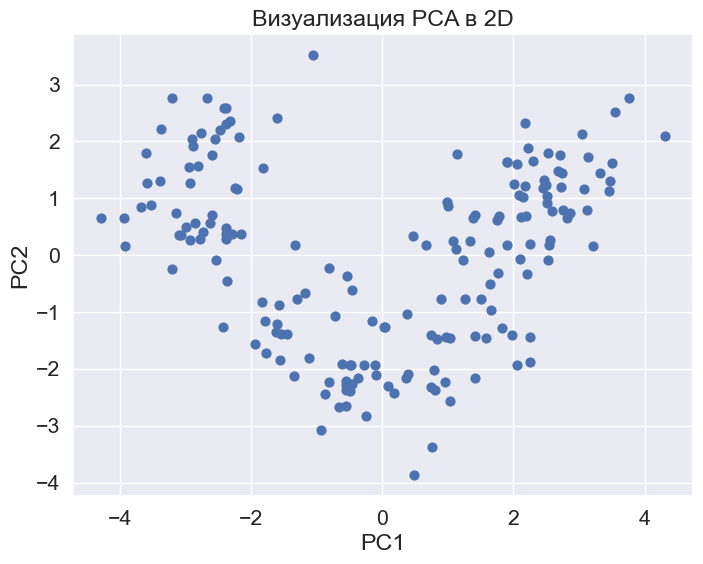

In [50]:
plt.figure(figsize=(8,6))

plt.scatter(df_pca.iloc[:,0], df_pca.iloc[:,1], s=40)

plt.title('Визуализация PCA в 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')

## t-SNE

Стохастическое вложение соседей с t-распределением (англ. t-Distributed Stochastic Neighbor Embedding, t-SNE) — метод визуализации данных высокой размерности с помощью представления каждой точки данных в двух или трехмерном пространстве, являющийся модификацией метода стохастического вложения соседей.

SNE начинается с преобразования многомерной евклидовой дистанции между точками в условные вероятности, отражающие сходство точек.

In [51]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df_tsne = pd.DataFrame(data = X_tsne, columns = ['tsne comp. 1', 'tsne comp. 2'])

print(f'Размер датасета: {df_tsne.shape}')
df_tsne.head()

Размер датасета: (178, 2)


,tsne comp. 1,tsne comp. 2
0,3.586677,-11.954519
1,4.113842,-7.972343
2,7.992424,-10.159496
3,5.981432,-12.799465
4,8.946787,-6.023237


### Визуализация t-SNE в 2D

Text(0, 0.5, 'tsne component 2')

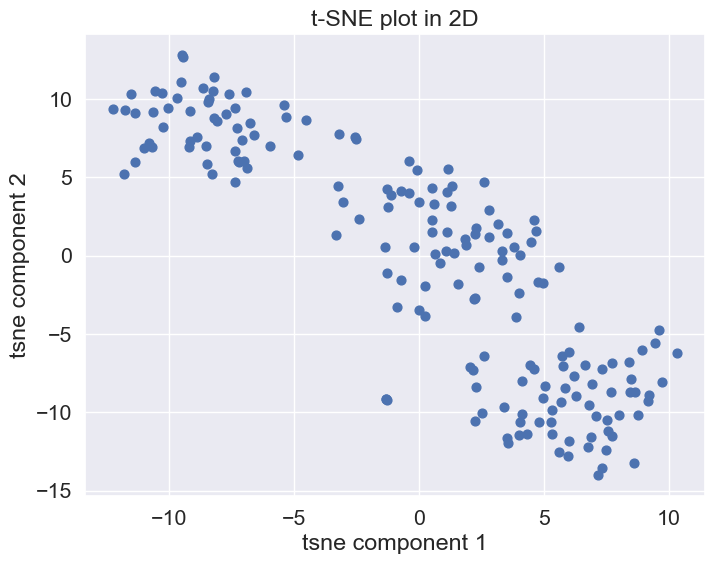

In [52]:
plt.figure(figsize=(8,6))

plt.scatter(df_tsne.iloc[:,0], df_tsne.iloc[:,1], s=40)

plt.title('t-SNE plot in 2D')
plt.xlabel('tsne component 1')
plt.ylabel('tsne component 2')

**Наблюдение**: Наиболее явно кластеры выделены на графике t-SNE.

## Кластеризация

### Алгоритм k-средних (k-Means)
1. Выбрать количество кластеров $k$, которое нам кажется оптимальным для наших данных.  
2. Высыпать случайным образом в пространство наших данных $k$ точек (центроидов).  
3. Для каждой точки нашего набора данных посчитать, к какому центроиду она ближе.  
4. Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.  
5. Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).

**Выбор числа кластеров:**  
В случае kMeans распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.

$$\Large J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

где $C$ – множество кластеров мощности $K$, $\mu_k$ - центроид кластера $C_k$.

Мы хотим, чтобы точки располагались кучно возле центров своих кластеров. Минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).
Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $J(C_k)$ падает "уже не так быстро".
$$\Large D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

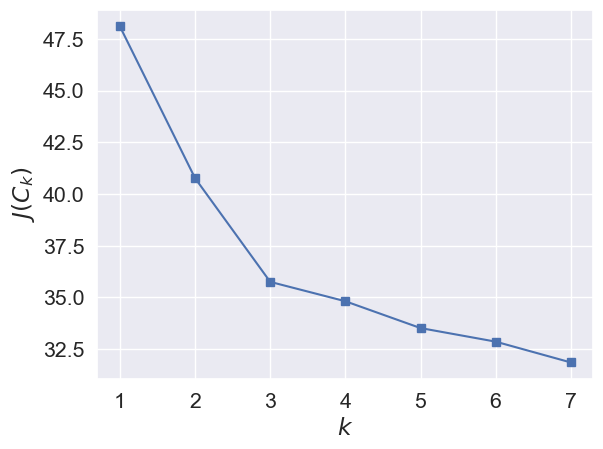

In [53]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

**Наблюдение**: $J(C_k)$ падает сильно при увеличении числа кластеров с 1 до 2 и с 2 до 3 и уже не так сильно – при изменении $k$ с 3 до 4. Значит, в данной задаче *действительно* оптимально задать 3 кластера.

### Affinity Propagation

Не требует заранее определять число кластеров, на которое мы хотим разбить наши данные. Основная идея алгоритма заключается в том, что нам хотелось бы, чтобы наши наблюдения кластеризовались в группы на основе того, как они "общаются", или насколько они похожи друг на друга.

### Агломеративная кластеризация (Agglomerative Clustering)
1. Высыпаем на каждую точку свой кластер
2. Сортируем попарные расстояния между центрами кластеров по возрастанию
3. Берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера
4. Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер

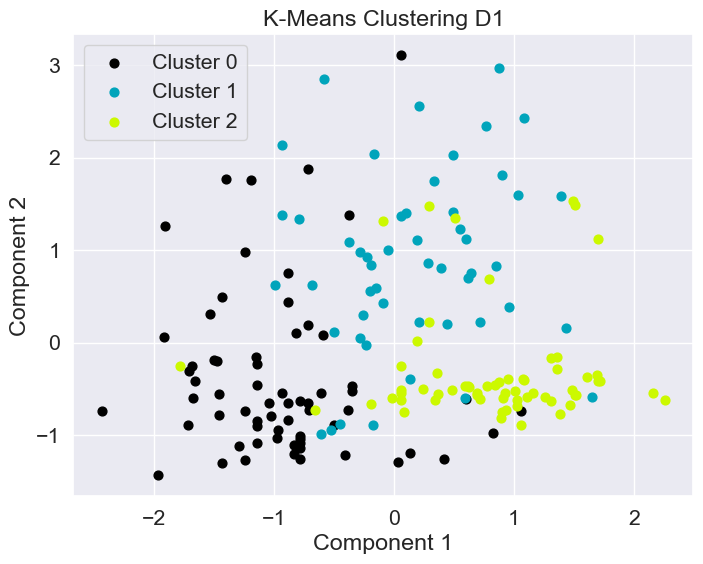

K-Means Clustering D1 - Silhouette Score: 0.28


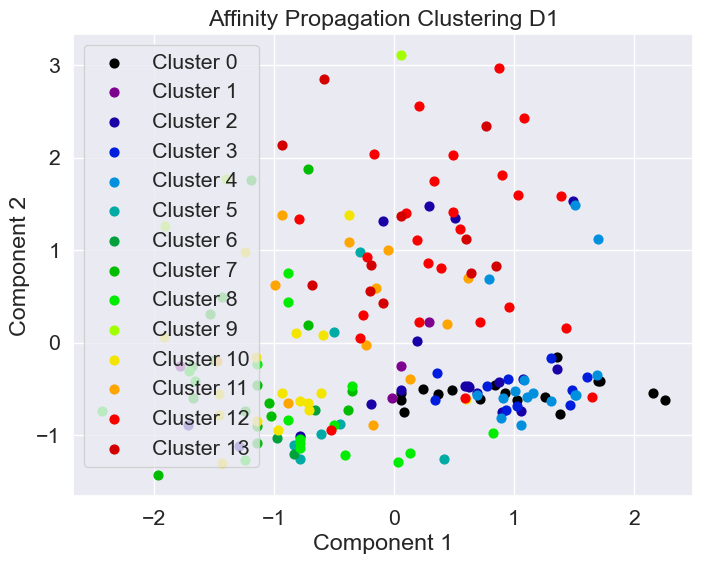

Affinity Propagation Clustering D1 - Silhouette Score: 0.12


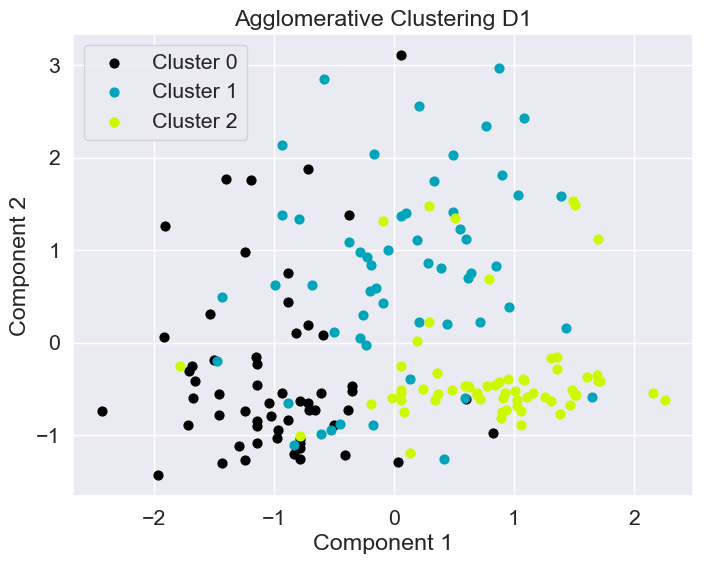

Agglomerative Clustering D1 - Silhouette Score: 0.28


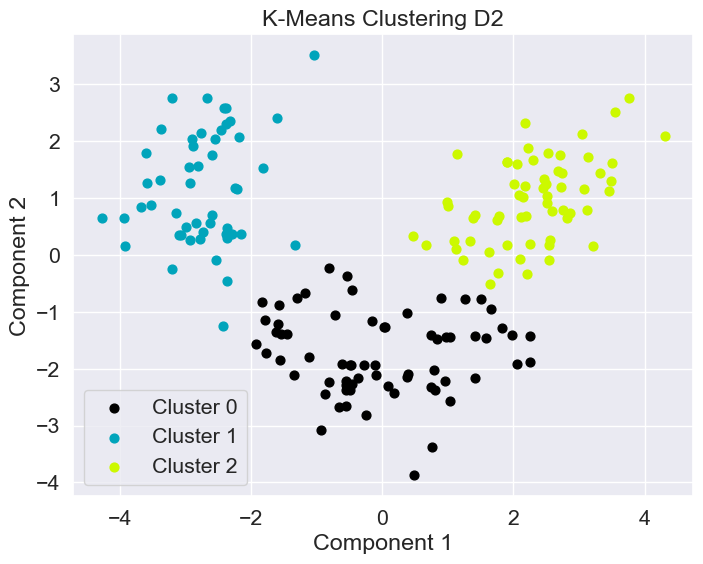

K-Means Clustering D2 - Silhouette Score: 0.56


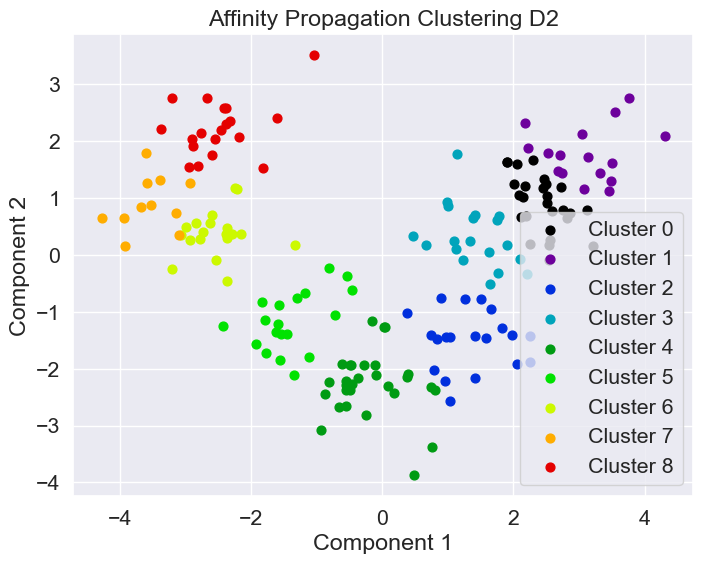

Affinity Propagation Clustering D2 - Silhouette Score: 0.37


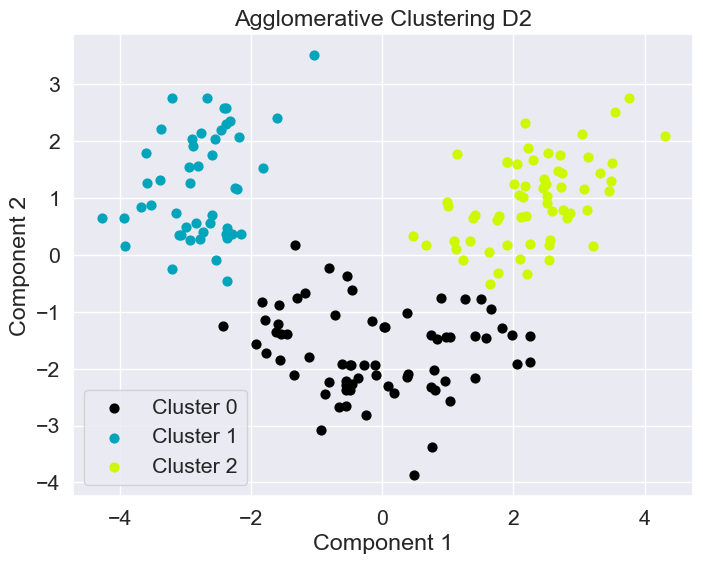

Agglomerative Clustering D2 - Silhouette Score: 0.56


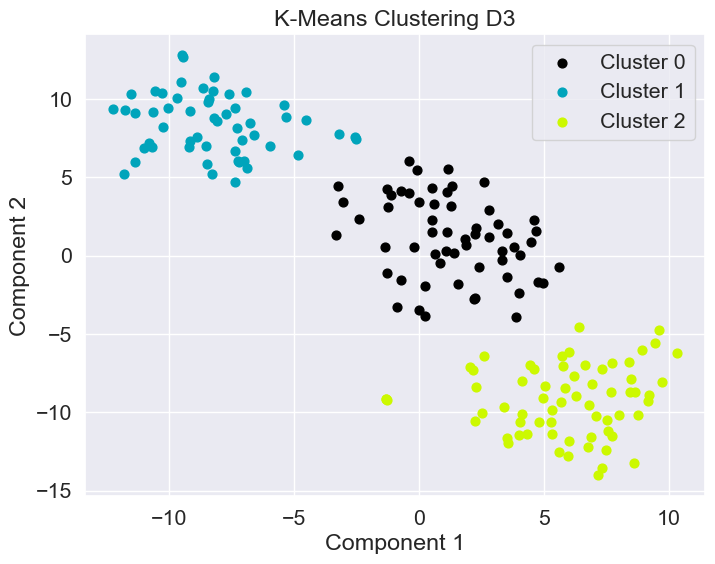

K-Means Clustering D3 - Silhouette Score: 0.61


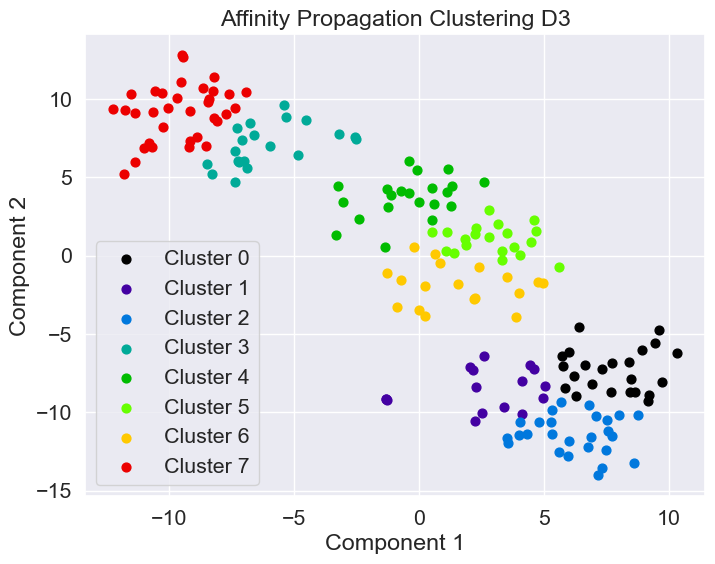

Affinity Propagation Clustering D3 - Silhouette Score: 0.36


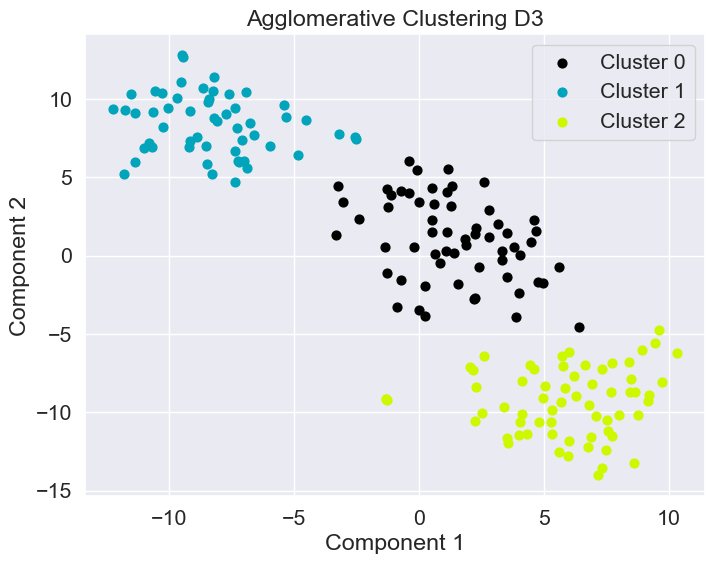

Agglomerative Clustering D3 - Silhouette Score: 0.61


In [60]:
# Функция для визуализации кластеров
def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        # Для AffinityPropagation метки могут быть отрицательными (шум), так что обойдем этот случай
        c = 'k' if label == -1 else plt.cm.nipy_spectral(float(label) / len(unique_labels))
        plt.scatter(data[labels == label, 0], data[labels == label, 1], s=40, label=f'Cluster {label}', color=c)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

# Функция для оценки кластеризации
def evaluate_clustering(data, labels, title):
    num_labels = len(set(labels))
    if num_labels > 1:  # Вычисляйте только если более чем один кластер
        score = silhouette_score(data, labels)
        print(f"{title} - Silhouette Score: {score:.2f}")
    else:
        print(f"{title} - Only one cluster found. Silhouette Score not applicable.")

# Кластеризация и визуализация для D1
kmeans_d1 = KMeans(n_clusters=3, random_state=42)
clusters_kmeans_d1 = kmeans_d1.fit_predict(X)
plot_clusters(X.values, clusters_kmeans_d1, 'K-Means Clustering D1')
evaluate_clustering(X, clusters_kmeans_d1, 'K-Means Clustering D1')

aff_prop_d1 = AffinityPropagation(random_state=42)
clusters_aff_prop_d1 = aff_prop_d1.fit_predict(X)
plot_clusters(X.values, clusters_aff_prop_d1, 'Affinity Propagation Clustering D1')
evaluate_clustering(X, clusters_aff_prop_d1, 'Affinity Propagation Clustering D1')

agglo_d1 = AgglomerativeClustering(n_clusters=3)
clusters_agglo_d1 = agglo_d1.fit_predict(X)
plot_clusters(X.values, clusters_agglo_d1, 'Agglomerative Clustering D1')
evaluate_clustering(X, clusters_agglo_d1, 'Agglomerative Clustering D1')

# Кластеризация и визуализация для D2
kmeans_d2 = KMeans(n_clusters=3, random_state=42)
clusters_kmeans_d2 = kmeans_d2.fit_predict(df_pca)
plot_clusters(df_pca.values, clusters_kmeans_d2, 'K-Means Clustering D2')
evaluate_clustering(df_pca, clusters_kmeans_d2, 'K-Means Clustering D2')

aff_prop_d2 = AffinityPropagation(random_state=42)
clusters_aff_prop_d2 = aff_prop_d2.fit_predict(df_pca)
plot_clusters(df_pca.values, clusters_aff_prop_d2, 'Affinity Propagation Clustering D2')
evaluate_clustering(df_pca, clusters_aff_prop_d2, 'Affinity Propagation Clustering D2')

agglo_d2 = AgglomerativeClustering(n_clusters=3)
clusters_agglo_d2 = agglo_d2.fit_predict(df_pca)
plot_clusters(df_pca.values, clusters_agglo_d2, 'Agglomerative Clustering D2')
evaluate_clustering(df_pca, clusters_agglo_d2, 'Agglomerative Clustering D2')

# Кластеризация и визуализация для D3
kmeans_d3 = KMeans(n_clusters=3, random_state=42)
clusters_kmeans_d3 = kmeans_d3.fit_predict(df_tsne)
plot_clusters(df_tsne.values, clusters_kmeans_d3, 'K-Means Clustering D3')
evaluate_clustering(df_tsne, clusters_kmeans_d3, 'K-Means Clustering D3')

aff_prop_d3 = AffinityPropagation(random_state=42)
clusters_aff_prop_d3 = aff_prop_d3.fit_predict(df_tsne)
plot_clusters(df_tsne.values, clusters_aff_prop_d3, 'Affinity Propagation Clustering D3')
evaluate_clustering(df_tsne, clusters_aff_prop_d3, 'Affinity Propagation Clustering D3')

agglo_d3 = AgglomerativeClustering(n_clusters=3)
clusters_agglo_d3 = agglo_d3.fit_predict(df_tsne)
plot_clusters(df_tsne.values, clusters_agglo_d3, 'Agglomerative Clustering D3')
evaluate_clustering(df_tsne, clusters_agglo_d3, 'Agglomerative Clustering D3')

## Оценка качества кластеризации

### Силуэт

Данный коэффициент **не** предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ — среднее расстояние от данного объекта до объектов из того же кластера, через $b$ — среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина:

$s = \frac{b - a}{\max(a, b)}.$


Силуэтом выборки называется средняя величина силуэта объектов данной выборки.   
Таким образом, **силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров.**   

Данная величина лежит в диапазоне $[-1, 1]$.   
Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) — выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

In [61]:
# Функция для выполнения кластеризации и оценки силуэта
def clustering_and_evaluation(data, dataset_name):
    # Создаем словарь для хранения результатов
    results = {'Method': [], 'Silhouette Score': []}
    
    # K-Means
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters_kmeans = kmeans.fit_predict(data)
    score_kmeans = silhouette_score(data, clusters_kmeans)
    results['Method'].append('K-Means')
    results['Silhouette Score'].append(score_kmeans)

    # Affinity Propagation
    aff_prop = AffinityPropagation(random_state=42)
    clusters_aff_prop = aff_prop.fit_predict(data)
    # Проверяем, что кластеров больше одного для оценки силуэтного коэффициента
    if len(set(clusters_aff_prop)) > 1:
        score_aff_prop = silhouette_score(data, clusters_aff_prop)
    else:
        score_aff_prop = float('nan')
    results['Method'].append('Affinity Propagation')
    results['Silhouette Score'].append(score_aff_prop)

    # Agglomerative Clustering
    agglo = AgglomerativeClustering(n_clusters=3)
    clusters_agglo = agglo.fit_predict(data)
    score_agglo = silhouette_score(data, clusters_agglo)
    results['Method'].append('Agglomerative')
    results['Silhouette Score'].append(score_agglo)
    
    # Формируем DataFrame и выводим результаты
    df_results = pd.DataFrame(results)
    df_results.index = [f"{dataset_name} - {method}" for method in results['Method']]
    print(f"Silhouette Scores for {dataset_name}:")
    print(df_results)
    print("\n")

# Оценка для всех трех наборов данных
clustering_and_evaluation(X, 'D1')
clustering_and_evaluation(df_pca, 'D2')
clustering_and_evaluation(df_tsne, 'D3')

Silhouette Scores for D1:
                                         Method  Silhouette Score
D1 - K-Means                            K-Means          0.284859
D1 - Affinity Propagation  Affinity Propagation          0.120949
D1 - Agglomerative                Agglomerative          0.277444


Silhouette Scores for D2:
                                         Method  Silhouette Score
D2 - K-Means                            K-Means          0.560170
D2 - Affinity Propagation  Affinity Propagation          0.373584
D2 - Agglomerative                Agglomerative          0.559088


Silhouette Scores for D3:
                                         Method  Silhouette Score
D3 - K-Means                            K-Means          0.613288
D3 - Affinity Propagation  Affinity Propagation          0.364064
D3 - Agglomerative                Agglomerative          0.608761


